In [9]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 68.9 MB/s eta 0:00:00:00:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached contourpy-1.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [4]:
import os
import numpy as np
import cv2
from PIL import Image as im
from datasets.transforms import TransformFixMatchWafer
from datasets.transforms import MaskedBernoulliNoise, ToWBM
from argparse import Namespace
import albumentations as A

/home/user/anaconda3/envs/FixMatch-pytorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
args = Namespace()
args.size_xy = 32
args.proportion = 1.0
args.arch = 'wideresnet'
args.model_depth = 28
args.model_width = 2
args.num_classes  = 8
args.keep = False

In [6]:
out = cv2.imread("data/wm811k/labeled/test/loc/000019.png", cv2.IMREAD_GRAYSCALE)
image = im.fromarray(out)

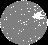

In [7]:
image

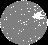

In [8]:
from PIL import Image

out1 = cv2.imread("data/wm811k/labeled/test/loc/000019.png", cv2.IMREAD_GRAYSCALE)
image1 = im.fromarray(out1)

out2 = cv2.imread("data/wm811k/labeled/test/loc/000646.png", cv2.IMREAD_GRAYSCALE)
image2 = im.fromarray(out2)


image1

In [9]:
image2

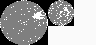

In [10]:
new_image = Image.new('RGB',(2*image1.size[0], image1.size[1]))
new_image.paste(image1,(0,0))
new_image.paste(image2,(image1.size[0],0))

# new_image.save("images/merged_image.jpg","JPEG")
new_image

In [24]:
transform_cutout = A.Compose([
    A.Cutout(num_holes=4, max_h_size=10, max_w_size=10, fill_value=0, p=1.0)
])

transform_noise = A.Compose([
    ToWBM(),
    MaskedBernoulliNoise(noise=0.2)])


# changed!!!
transform_rotate = A.Compose([
    A.Rotate(limit=(-180, 180), interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, p=1.0)
])

transform_shift = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.5,
                       scale_limit=0,
                       rotate_limit=0,
                       interpolation=cv2.INTER_NEAREST,
                       border_mode=cv2.BORDER_CONSTANT,
                       value=0,
                       p=1.0)])


"""
class albumentations.augmentations.crops.transforms.Crop (x_min=0, y_min=0, x_max=1024, y_max=1024, always_apply=False, p=1.0) [view source on GitHub] ¶
Crop region from image.
"""



"""
height	int	 height after crop and resize.
width	int	 width after crop and resize.
scale	[float, float]	range of size of the origin size cropped
ratio	[float, float]	range of aspect ratio of the origin aspect ratio cropped
interpolation	OpenCV flag  flag that is used to specify the interpolation algorithm. Should be one of: cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4. Default: cv2.INTER_LINEAR.
p	float	probability of applying the transform. Default: 1.
"""
transform_crop = A.Compose([
    A.RandomResizedCrop(32, 32, scale=(0.7, 0.9), ratio=(1.0 ,1.0), interpolation=cv2.INTER_NEAREST, p=1.0)
])

# transform_crop = A.Compose([
#     A.RandomResizedCrop(32, 32, scale=(0.5, 0.7), ratio=(0.9,1.1), interpolation=cv2.INTER_NEAREST, p=1.0)
# ])

transform_optical_distortion = A.Compose([
        A.OpticalDistortion(p=1.0),
    ])


transform_grid_distortion = A.Compose([
        A.GridDistortion(p=1.0),
    ])


transform_elastic = A.Compose([
        A.ElasticTransform(p=1.0),
    ])


/home/user/anaconda3/envs/FixMatch-pytorch/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [25]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import matplotlib

def showImagesMatrix(list_images, col=7, wSize=10, hSize=10):
    fig = figure(figsize=(wSize, hSize))
    number_of_files = len(list_images)
    row = int(number_of_files / col)
    # print(number_of_files, row, col)
    if (number_of_files % col != 0):
        row += 1
    for i in range(number_of_files):
        a=fig.add_subplot(row, col, i + 1)
        imshow(list_images[i], cmap='Greys_r')
        axis('off')

In [26]:
image_origin = out
image_cutout = transform_cutout(image=out)['image']
image_crop   = transform_crop(image=out)['image']
image_noise  = ((transform_noise(image=out)['image'] * 255) / 2).astype(np.uint8)
image_rotate = transform_rotate(image=out)['image']
image_shift  = transform_shift(image=out)['image']


# newly added
image_optical_distortion  = transform_optical_distortion(image=out)['image']
image_grid_distortion  = transform_grid_distortion(image=out)['image']
image_elastic  = transform_elastic(image=out)['image']

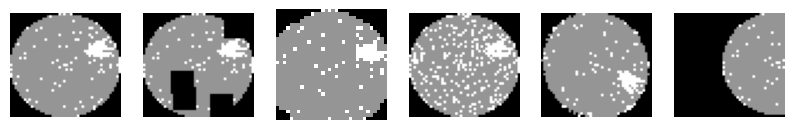

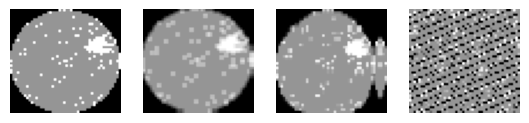

In [28]:
showImagesMatrix([image_origin, image_cutout, image_crop, image_noise, image_rotate, image_shift], col=6)
showImagesMatrix([image_origin, image_optical_distortion, image_grid_distortion, image_elastic], col=6)

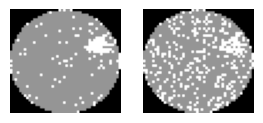

In [17]:
showImagesMatrix([image_origin, image_noise], col=6)


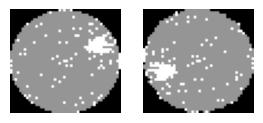

In [9]:
showImagesMatrix([image_origin, image_rotate], col=6)

2 0 6
2 0 6


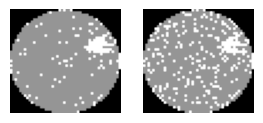

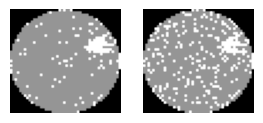

In [139]:
showImagesMatrix([image_origin, image_noise], col=6)
showImagesMatrix([image_origin, image_noise], col=6)


In [140]:
transform_noise = A.Compose([
    ToWBM(),
    MaskedBernoulliNoise(noise=0.2)])

In [96]:
transform_noise

Compose([
  ToWBM(always_apply=True, p=1.0),
  MaskedBernoulliNoise(always_apply=False, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [98]:
new_transform

Compose([
  OpticalDistortion(always_apply=False, p=0.3, distort_limit=(-0.05, 0.05), shift_limit=(-0.05, 0.05), interpolation=1, border_mode=4, value=None, mask_value=None),
  GridDistortion(always_apply=False, p=0.1, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None, normalized=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

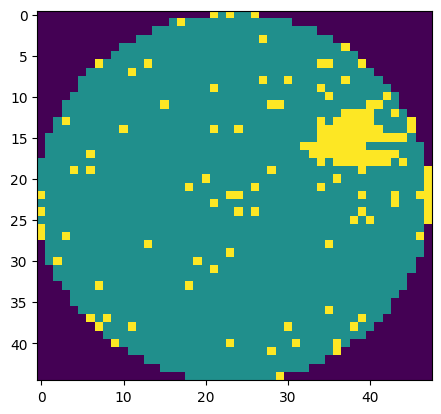

In [100]:
plt.imshow(new_transform(image=out)['image'])